# <div align='center' id="top"> Training  age prediction task  </div>

## `Table of contents`

- ###  <a href="#label">Data Labeling</a>
- ###  <a href="#model">Model Building</a>
- ###  <a href="#train">Model Training & Evaluation</a>


### <div align='center' id="label">Data Labeling</div>



<div align = "right"><a href="#top" > Back to top </a></div>

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [5]:
# Paths
DATA_DIR =  "precise_age_split"
TRAIN_DIR = "percise_age_split/train"
TEST_DIR = "percise_age_split/test"

IMG_SIZE = 112  # 112x112
def load_dataset(folder_path):
    X = []
    y = []
    for age_str in os.listdir(folder_path):
        age_path = os.path.join(folder_path, age_str)
        if not os.path.isdir(age_path):
            continue
        age = int(age_str)
        for img_name in os.listdir(age_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(age_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img.astype('float32') / 255.0  # Normalize to [0, 1]
                X.append(img)
                y.append(age)
    return np.array(X), np.array(y)

# Load training data
X_train, y_train = load_dataset(TRAIN_DIR)

# Load and split test data into validation and test (50/50)
X_test_full, y_test_full = load_dataset(TEST_DIR)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_full, y_test_full, test_size=0.5, stratify=y_test_full, random_state=42
)

# Print info
print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"✅ X_test:  {X_test.shape}, y_test:  {y_test.shape}")
print(f"🧠 Age range: {np.min(y_train)} to {np.max(y_train)}")
print(f"📊 Train age distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")


✅ X_train: (59057, 112, 112), y_train: (59057,)
✅ X_val:   (2009, 112, 112), y_val:   (2009,)
✅ X_test:  (2009, 112, 112), y_test:  (2009,)
🧠 Age range: 11 to 80
📊 Train age distribution: {11: 260, 12: 520, 13: 320, 14: 625, 15: 705, 16: 985, 17: 630, 18: 1045, 19: 390, 20: 1135, 21: 1380, 22: 1500, 23: 1500, 24: 1500, 25: 1500, 26: 1757, 27: 1500, 28: 1500, 29: 1500, 30: 1500, 31: 1400, 32: 1500, 33: 570, 34: 1500, 35: 1500, 36: 1500, 37: 1170, 38: 1300, 39: 1060, 40: 1500, 41: 525, 42: 1060, 43: 625, 44: 400, 45: 1500, 46: 610, 47: 680, 48: 610, 49: 590, 50: 1500, 51: 550, 52: 925, 53: 960, 54: 1410, 55: 1070, 56: 940, 57: 385, 58: 1080, 59: 325, 60: 1170, 61: 640, 62: 500, 63: 410, 64: 200, 65: 1035, 66: 305, 67: 375, 68: 400, 69: 220, 70: 585, 71: 130, 72: 390, 73: 250, 74: 125, 75: 590, 76: 230, 77: 110, 78: 275, 79: 90, 80: 530}


### <div align='center' id="model">Model Building</div>



<div align = "right"><a href="#top" > Back to top </a></div>

Two models will be trained 

1) a VGG16 model from scratch but with fewer parameters 
- reduce the 1st FC layer to 512 neurons with dropout of 0.5 
- reduce the 2nd FC layer to 256 neurons with dropout of 0.3 instead of 0.5 

2) an SSR-Net Arch (Usually recomendded for facial age estimation) + DEX `Expectation` Trick

In [27]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


In [31]:
def vgg16_age(input_shape=(112, 112, 1)):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 5 (Optional or smaller)
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    
    # Regression output
    model.add(Dense(1, activation='linear'))  # Predicts age

    model.summary()
    return model


In [ ]:
def SSRNet_with_DEX(input_shape=(112, 112, 1), stage_num=[3, 3, 3], num_classes=70):
    def conv_block(x, filters, name):
        x = Conv2D(filters, (3, 3), padding='same', name=f'{name}_conv')(x)
        x = BatchNormalization(name=f'{name}_bn')(x)
        x = Activation('relu', name=f'{name}_relu')(x)
        return x

    input_layer = Input(shape=input_shape, name='input')

    # Backbone CNN
    x = conv_block(input_layer, 32, 'conv1_1')
    x = conv_block(x, 32, 'conv1_2')
    x = MaxPooling2D((2, 2), name='pool1')(x)

    x = conv_block(x, 64, 'conv2_1')
    x = conv_block(x, 64, 'conv2_2')
    x = MaxPooling2D((2, 2), name='pool2')(x)

    x = conv_block(x, 128, 'conv3_1')
    x = conv_block(x, 128, 'conv3_2')
    x = MaxPooling2D((2, 2), name='pool3')(x)

    x = conv_block(x, 256, 'conv4_1')
    x = conv_block(x, 256, 'conv4_2')
    x = MaxPooling2D((2, 2), name='pool4')(x)

    x = conv_block(x, 512, 'conv5_1')
    x = conv_block(x, 512, 'conv5_2')
    x = AveragePooling2D(pool_size=(7, 7), name='avg_pool')(x)

    x_flat = Flatten(name='flatten')(x)

    # ===== SSR Branch =====
    def SSR_stage(x, stage_idx):
        m = Dense(stage_num[stage_idx], activation='softmax', name=f'stage{stage_idx+1}_m')(x)
        s = Dense(stage_num[stage_idx], activation='tanh', name=f'stage{stage_idx+1}_s')(x)
        return m, s

    m1, s1 = SSR_stage(x_flat, 0)
    m2, s2 = SSR_stage(x_flat, 1)
    m3, s3 = SSR_stage(x_flat, 2)

    def SSR_weighted_sum(m, s, stage_n, name):
        def compute_sum(p):
            idx = tf.range(0, stage_n, dtype=tf.float32)
            return tf.reduce_sum((p[0] + p[1]) * idx, axis=1, keepdims=True)
        return Lambda(compute_sum, name=name)([m, s])

    lambda_local = 0.25
    stage_weights = [1.0, 0.5, 0.25]

    local_pred1 = SSR_weighted_sum(m1, s1 * lambda_local, stage_num[0], 'local_pred1')
    local_pred2 = SSR_weighted_sum(m2, s2 * lambda_local, stage_num[1], 'local_pred2')
    local_pred3 = SSR_weighted_sum(m3, s3 * lambda_local, stage_num[2], 'local_pred3')

    age_ssr = Lambda(lambda x: x[0]*stage_weights[0] + x[1]*stage_weights[1] + x[2]*stage_weights[2],
                     name='age_ssr')([local_pred1, local_pred2, local_pred3])

    age_ssr_scaled = Lambda(lambda x: x * (70.0 / sum(stage_weights)) + 11.0,
                            name='age_ssr_scaled')(age_ssr)

    # ===== DEX Branch =====
    dex_branch = Dense(256, activation='relu', name='dex_fc1')(x_flat)
    dex_branch = Dropout(0.5, name='dex_dropout')(dex_branch)
    dex_logits = Dense(num_classes, activation='softmax', name='dex_logits')(dex_branch)

    # Expected age from softmax (class values from 11 to 80)
    def dex_expected_age(p):
        age_values = tf.range(11., 81., dtype=tf.float32)
        return tf.reduce_sum(p * age_values, axis=1, keepdims=True)

    age_dex = Lambda(dex_expected_age, name='age_dex')(dex_logits)

    # ===== Fusion Layer ===== (learned weights for SSR vs DEX)
    fusion_weights = Dense(2, activation='softmax', name='fusion_weights')(x_flat)
    final_age = Lambda(
        lambda p: p[0] * p[2][:, 0:1] + p[1] * p[2][:, 1:2],
        name='final_age'
    )([age_ssr_scaled, age_dex, fusion_weights])

    # ===== Final Model =====
    model = Model(inputs=input_layer, outputs=final_age, name='SSRNet_with_DEX')
    model.summary()
    return model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def train_model(model_fn, X_train, y_train, X_val, y_val,
                learning_rate=0.0001, batch_size=128, epochs=15, patience=5,
                checkpoint_path="best_model.h5"):

    # Build the model
    model = model_fn()

    # Compile model with Huber loss and MAE metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=Huber(),  
                  metrics=['mae'])  

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    # Train
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, reduce_lr, checkpoint],
                        verbose=1)

    return model, history


In [17]:
def evaluate_and_plot_results(model_fn, model, history, X_train, y_train, X_test, y_test):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error

    # Evaluate final model
    train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_mae   = model.evaluate(X_test, y_test, verbose=0)
    val_mae = history.history['val_mae'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"\nTrain Loss: {train_loss:.4f} | Train MAE: {train_mae:.2f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   MAE: {val_mae:.2f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  MAE: {test_mae:.2f}")

    # Identify best epoch (lowest val_loss)
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch]
    best_val_mae = history.history['val_mae'][best_epoch]

    print(f"\n Best Epoch: {best_epoch + 1} | Best Val Loss: {best_val_loss:.4f} | Best Val MAE: {best_val_mae:.2f}")

    # Plot Loss and MAE
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch {best_epoch + 1}')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['mae'], label='Train MAE')
    axs[1].plot(history.history['val_mae'], label='Val MAE')
    axs[1].scatter(best_epoch, best_val_mae, color='red', label=f'Best Epoch {best_epoch + 1}')
    axs[1].set_title('MAE over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Predict and scatter plot
    y_pred = model.predict(X_test).flatten()

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True Age")
    plt.ylabel("Predicted Age")
    plt.title("Predicted vs True Age")
    plt.grid(True)
    plt.show()

### <div align='center' id="train"> Training & Evaluation</div>



<div align = "right"><a href="#top" > Back to top </a></div>

### VGG

In [ ]:
model, history = train_model(
    model_fn=vgg16_age,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    learning_rate=0.0001,
    batch_size=128,         
    epochs=30,
    patience=5,
    checkpoint_path="vgg_age.h5"
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 128)      0         
 2D)                                                    


Train Loss: 3.0023 | Train MAE: 3.47
Val   Loss: 5.6436 | Val   MAE: 6.12
Test  Loss: 5.5907 | Test  MAE: 6.07

 Best Epoch: 16 | Best Val Loss: 5.5330 | Best Val MAE: 6.01


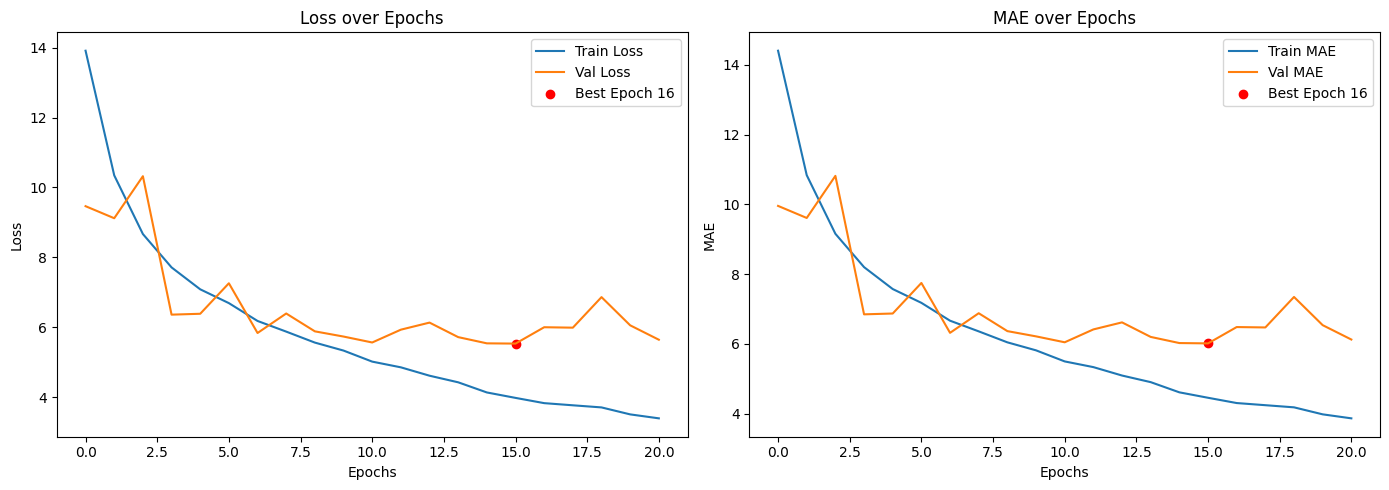

63/63 [==============================] - 35s 557ms/step


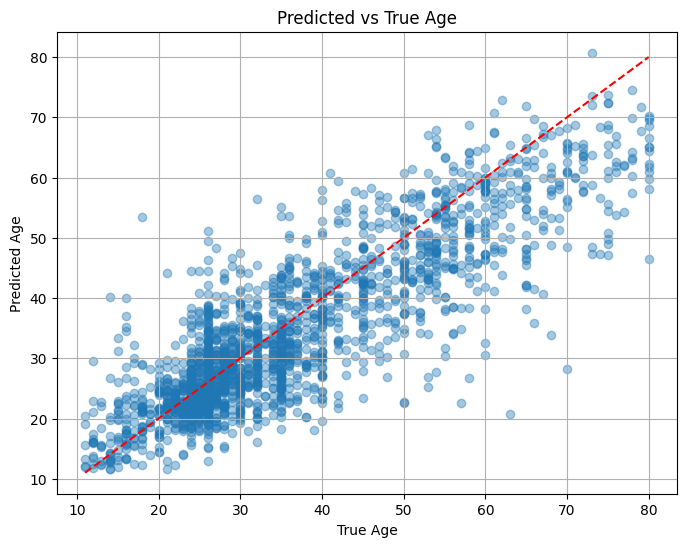

In [ ]:
evaluate_and_plot_results(
    model_fn=vgg16_age,
    model=model,
    history=history,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)


### SSR

In [50]:
model_ssr, history_ssr = train_model(
    model_fn=SSRNet_with_DEX,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    learning_rate=0.0001,
    batch_size=128,         
    epochs=30,
    patience=5,
    checkpoint_path="ssr.h5"
)


Model: "SSRNet_with_DEX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1_conv (Conv2D)          (None, 112, 112, 32  320         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 112, 112, 32  128        ['conv1_1_conv[0][0]']           
 )                              )                                                   


Train Loss: 4.8839 | Train MAE: 5.36
Val   Loss: 6.3573 | Val   MAE: 6.84
Test  Loss: 5.8166 | Test  MAE: 6.29

 Best Epoch: 4 | Best Val Loss: 5.6471 | Best Val MAE: 6.13


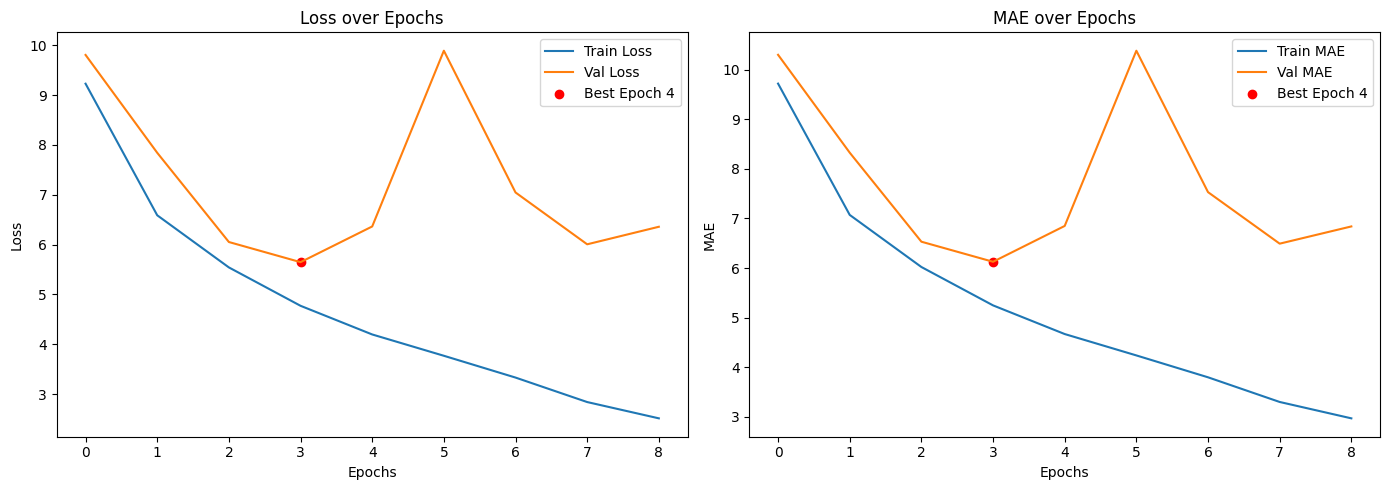

63/63 [==============================] - 12s 186ms/step


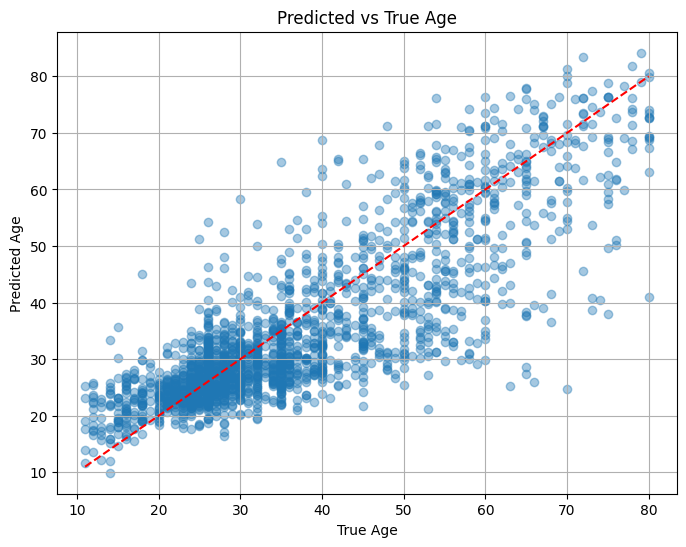

In [51]:
evaluate_and_plot_results(
    model_fn=SSRNet_with_DEX,
    model=model_ssr,
    history=history_ssr,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)